In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import credentials
import numpy as np
import sqlconnector as sql
import pickle5 as pickle
from scipy.stats import zscore
from sklearn.decomposition import PCA
from scipy import stats

In [3]:
data = pickle.load(open('data_new.pickle', "rb"))

In [11]:
# Data cleaning for CSI 300 - download daily historical data from https://www.investing.com/indices/csi300-historical-data

df_csi = pd.read_csv('CSI300.csv')

df_csi = df_csi.apply(lambda x: x.str.replace(',',''))
df_csi = df_csi.apply(lambda x: x.str.replace('K','000'))
df_csi = df_csi.apply(lambda x: x.str.replace('%',''))

df_csi.Date = pd.to_datetime(df_csi.Date)
df_csi = df_csi.sort_values(by='Date')
df_csi = df_csi[df_csi.Date >= dates[0] - pd.Timedelta('5d')]

df_csi = df_csi.reset_index(drop=True)
df_csi.index = df_csi.Date
df_csi.head()

df_csi = df_csi.iloc[:,1:].apply(pd.to_numeric)

In [12]:
# Fill in dates that have no data

idx = pd.date_range(df_csi.index[0], df_csi.index[-1])
df_csi = df_csi.reindex(idx).fillna(method='ffill')

In [13]:
df_csi.head()

,Price,Open,High,Low,Vol.,Change %
2017-01-26,3387.96,3378.26,3395.88,3378.26,65.32,0.36
2017-01-27,3387.96,3378.26,3395.88,3378.26,65.32,0.36
2017-01-28,3387.96,3378.26,3395.88,3378.26,65.32,0.36
2017-01-29,3387.96,3378.26,3395.88,3378.26,65.32,0.36
2017-01-30,3387.96,3378.26,3395.88,3378.26,65.32,0.36


In [14]:
# Calculate one month ahead return

after = df_csi.reindex(df_csi.index + pd.DateOffset(months=1))
after.index = df_csi.index
df_csi['ret'] = (after['Price']/df_csi['Price'] - 1).fillna(method='ffill')

In [ ]:
#benchmark = df_csi.loc[dates]['ret'].values

In [6]:
data.iloc[:,1:] = data.iloc[:,1:].apply(pd.to_numeric)


In [7]:
data.statistic_date = pd.to_datetime(data.statistic_date)

In [8]:
data.head()

,statistic_date,fund_id,ret,fee,securities_settlement_receivable,provision_settlement_fund,stock_income,total_assets,total_liabilities,refundable_deposits,...,total_skewness,total_kurtosis,total_con_rise_days,total_con_fall_days,quarter_return,total_n_earning_days,total_odds,total_max_drawdown,total_p_earning_days,total_return
0,2017-01-31,8,0.035794,0.005,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.031244,3.479692,9.0,6.0,-0.004176,392.0,0.585526,0.530764,522.0,0.706825
1,2017-02-28,8,-0.003764,0.005,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.042016,3.587010,9.0,6.0,0.031469,397.0,0.588172,0.530764,534.0,0.767920
2,2017-03-31,8,-0.028563,0.005,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.047920,3.712064,9.0,6.0,0.027587,408.0,0.585519,0.530764,546.0,0.761266
3,2017-04-30,8,-0.057333,0.005,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.044859,3.762351,9.0,7.0,-0.028563,417.0,0.583934,0.530764,555.0,0.710959
4,2017-05-31,8,0.054007,0.005,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.036409,3.797064,9.0,7.0,-0.084259,430.0,0.579213,0.530764,562.0,0.612864


In [9]:
dates = sorted(data.statistic_date.unique())

In [59]:
features = data.columns[5:]

In [60]:
def quantile(data, features, num_funds=50, month=1):
    '''
    function that computes pnl over time for quantile trading with rebalancing every (t=month) months
        
    inputs: data(pd dataframe), features(list), num_funds(integer) - number of
        funds we hold every month, month(integer) - number of month we are rebalancing
        for
    output: a dict where keys are features and values are list of pnls over time
    '''
    
    dates = sorted(pd.to_datetime(data.statistic_date.unique()))
    pnl = {}
    for feature in features:
        pnl[feature] = []
        for date in dates[::month]:
            df = data[(data.statistic_date == date) & (data[feature].isna() == False)].sort_values(by=feature, ascending=False)
            ret = 0
            funds = df.fund_id[:num_funds]
            if month == 1:
                ret += sum(df.ret[:num_funds])/num_funds
            else:
                
                # Iterate through funds and calculate t - month look ahead return
                for fund in funds:
                    ret_per_fund = 1
                    for i in range(month):
                        if i == 0:
                            ret_per_fund *= (1+df[df.fund_id == fund].ret.values[0]/num_funds)
                        else:
                            month_ret = data[(data.statistic_date == (date + pd.DateOffset(months=i))) & (data.fund_id == fund)].ret.values
                            if month_ret.size > 0:
                                ret_per_fund *= (1 + month_ret[0]/num_funds)
                            else:
                                break
                    ret += ret_per_fund-1
            pnl[feature].append(ret)
    return pnl

In [77]:
data_df = data.copy()

In [88]:
test = data_df[[]]
test[top_20_feature[-5:]] = data_df[top_20_feature[-5:]]
test['composite'] = (test.subtract(test.mean(axis=1),axis=0)).div(test.std(axis=1),axis=0).sum(axis=1)
test['ret'] = data_df.ret
test['fund_id'] = data_df.fund_id
test['statistic_date'] = data_df.statistic_date

/Users/charles/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/var/folders/sj/x531msr155b2cnd1db8frnr00000gn/T/ipykernel_62429/2514961121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['composite'] = (test.subtract(test.mean(axis=1),axis=0)).div(test.std(axis=1),axis=0).sum(axis=1)
/var/folders/sj/x531msr155b2cnd1db8frnr00000gn/T/ipykernel_62429/2514961121.py:4: SettingWithCopyWarning: 
A value is trying to be

In [79]:
data_df[features] = data_df[features] - data_df[features].rolling(3).median()

In [107]:
pnl = quantile(data, features, 5, 1)

In [108]:
del pnl['ret_2m']
del pnl['ret_3m']

In [109]:
pnl_df = pd.DataFrame(pnl)

In [110]:
# Sort features in terms of total cumulative pnl and pick top 20

cumul_pnl = {}
for key, val in pnl.items():
    cumul_pnl[key] = sum(val)
    
sort_dic = dict(sorted(cumul_pnl.items(), key=lambda item: item[1]))
top_20_feature = list(sort_dic.keys())[-20:]

In [123]:
top_20_feature

['y1_excess_a',
 'm6_ddr3_a',
 'y1_return_a',
 'y1_tr_a',
 'm3_unsys_risk',
 'm3_sor_a',
 'm3_max_return',
 'y1_calmar_a',
 'y1_stock_hm',
 'total_mdd_time',
 'y1_downbeta_cl',
 'm6_downbeta_cl',
 'm6_stdev_a',
 'm6_stdev',
 'm6_max_return',
 'm6_unsys_risk',
 'y1_jensen_a',
 'm3_tracking_error_a',
 'm6_tracking_error_a',
 'y1_s_security']

In [112]:
import math

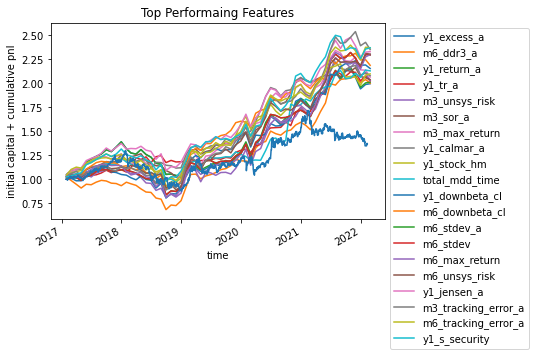

In [113]:
for fea in top_20_feature[:]:
    ts = pnl[fea]
    ts = [0 if math.isinf(x) else x for x in ts] 
    plt.plot(dates,np.cumsum(ts)+1)
    
(df_csi.Price/df_csi.Price[0]).plot(label='CSI')

plt.legend(top_20_feature[:],bbox_to_anchor=(1, 1))
plt.title('Top Performaing Features')
plt.xlabel('time')
plt.ylabel('initial capital + cumulative pnl')
plt.show()


In [114]:
# excess_pnl = {}
# for key, val in pnl.items():
#     excess_pnl[key] = val - benchmark
# excess_pnl_df = pd.DataFrame(excess_pnl)

In [115]:
# excess_pnl_df

In [116]:
def performance_matrix(df,metrics,annualized_factor = 12):

    performance_matrix = []
    for metric in metrics:
        if metric == 'mean':
            performance_matrix.append(df.mean() * annualized_factor)
        elif metric == 'volatility':
            performance_matrix.append(df.std() * np.sqrt(annualized_factor))
        elif metric == 'sharpe':
            performance_matrix.append(df.mean() * annualized_factor / (df.std() * np.sqrt(annualized_factor)))
        elif metric == 'skew':
            performance_matrix.append(df.skew())
        elif metric == 'excess_kurtosis':
            performance_matrix.append(df.kurtosis() - 3)
        elif metric == 'var':
            performance_matrix.append(df.quantile(0.05))
        elif metric =='cvar':
            performance_matrix.append(df[df < df.quantile(0.05)].mean())
        elif metric =='max_drawdown':
            cum_returns = (1 + df).cumprod()
            rolling_max = cum_returns.cummax()
            drawdown = (cum_returns - rolling_max) / rolling_max
            performance_matrix.append(drawdown.min())
        else:
            raise NoSuchMetricError( 'Metric ' + metric + ' is not valid!')
            
    performance_matrix = pd.concat(performance_matrix,axis=1)
    performance_matrix.columns = metrics

    return performance_matrix.T

In [117]:
performance_df = performance_matrix(pnl_df, ['mean', 'volatility', 'sharpe', 'max_drawdown']).transpose()

In [118]:
performance_df.sort_values(by='sharpe', ascending=False).head(10)

,mean,volatility,sharpe,max_drawdown
y1_tr_a,0.197885,0.163427,1.210842,-0.108319
y1_calmar_a,0.208647,0.172459,1.209835,-0.140212
m6_tracking_error_a,0.264453,0.230094,1.149325,-0.226873
y1_kappa_a,0.162224,0.141877,1.143414,-0.150577
y1_sor_a,0.171997,0.151747,1.133442,-0.169077
y1_jensen_a,0.256994,0.229834,1.118174,-0.263229
m3_sor_a,0.200748,0.179657,1.117396,-0.221941
m6_unsys_risk,0.252005,0.226240,1.113885,-0.236060
m6_downbeta_cl,0.229404,0.208304,1.101295,-0.260470
y1_sterling_a,0.169279,0.158061,1.070977,-0.191763


In [119]:
performance_df.sort_values(by='max_drawdown', ascending=False)

,mean,volatility,sharpe,max_drawdown
y1_tr_a,0.197885,0.163427,1.210842,-0.108319
y1_ERCVaR,0.056949,0.106252,0.535974,-0.121864
total_calmar_a,0.109674,0.151306,0.724850,-0.122049
y1_min_return,0.053601,0.125008,0.428780,-0.123685
y1_adjusted_jensen_a,0.144194,0.148913,0.968309,-0.123904
...,...,...,...,...
total_VaR,0.097737,0.199557,0.489772,-0.357144
total_dd_a,0.066452,0.205096,0.324007,-0.361834
total_CVaR,0.171996,0.360625,0.476939,-0.363813
quarter_return,0.153342,0.240445,0.637743,-0.371150


In [120]:
performance_df.sort_values(by='volatility')

,mean,volatility,sharpe,max_drawdown
total_kurtosis,0.062072,0.105493,0.588395,-0.133726
y1_ERCVaR,0.056949,0.106252,0.535974,-0.121864
total_p_earning_days,0.052512,0.106357,0.493735,-0.173412
y1_assess_ratio,0.050638,0.106471,0.475607,-0.152645
total_n_earning_days,0.051715,0.108610,0.476155,-0.177194
...,...,...,...,...
y1_s_security,0.264630,0.251097,1.053895,-0.301029
m6_jensen_a,0.147822,0.252009,0.586572,-0.331760
m6_max_return,0.250989,0.260091,0.965005,-0.310126
m6_s_security,0.159943,0.260185,0.614729,-0.331187


In [121]:
def quantile_all_features(data, features):
    
    col = features+['fund_id']
    dates = data.statistic_date.unique()
    pnl = []
    hold = []
    for date in dates[1:]:
        ret = 0
        for company in hold:
            try:
                ret += data[(data.statistic_date == date) & (data.fund_id == company)].ret.values[0]*0.05
            except:
                ret += 0
        pnl.append(ret)
        df = data[data.statistic_date == date][col].dropna()
        #print(df.columns)
        df['score'] = stats.zscore(df[features]).sum(axis=1)
        df = df.sort_values(by='score', ascending=False)
        #print(df.fund_id)
        hold = list(df.fund_id[:20])
        #print(hold)
            #print(len(df.fund_id), date)
    return pnl

In [122]:
top_20_feature

['y1_excess_a',
 'm6_ddr3_a',
 'y1_return_a',
 'y1_tr_a',
 'm3_unsys_risk',
 'm3_sor_a',
 'm3_max_return',
 'y1_calmar_a',
 'y1_stock_hm',
 'total_mdd_time',
 'y1_downbeta_cl',
 'm6_downbeta_cl',
 'm6_stdev_a',
 'm6_stdev',
 'm6_max_return',
 'm6_unsys_risk',
 'y1_jensen_a',
 'm3_tracking_error_a',
 'm6_tracking_error_a',
 'y1_s_security']

In [417]:
pnl = quantile(data, features)

In [217]:
pnl_top = quantile(data, features)

In [30]:
pnl_all_feature = quantile_all_features(data,top_20_feature)

Text(0, 0.5, 'dollar')

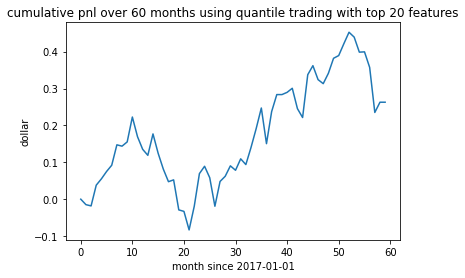

In [31]:
plt.plot(np.cumsum(pnl_all_feature))
plt.title('cumulative pnl over 60 months using quantile trading with top 20 features')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [32]:
pnl_top_5_feature = quantile_all_features(data,top_20_feature[-5:])

Text(0, 0.5, 'dollar')

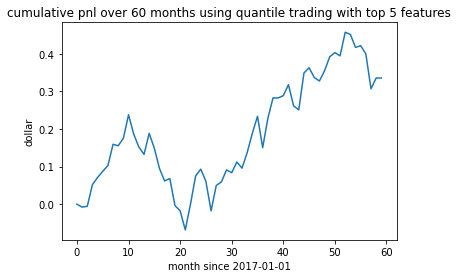

In [33]:
plt.plot(np.cumsum(pnl_top_5_feature))
plt.title('cumulative pnl over 60 months using quantile trading with top 5 features')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [34]:
pnl_top_10_feature = quantile_all_features(data,top_20_feature[-10:])

Text(0, 0.5, 'dollar')

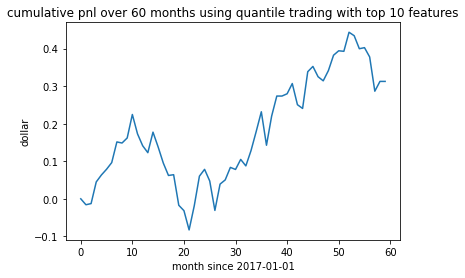

In [35]:
plt.plot(np.cumsum(pnl_top_10_feature))
plt.title('cumulative pnl over 60 months using quantile trading with top 10 features')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [36]:
pnl_all_feature_20_two = quantile_all_features_two_month(data,top_20_feature)

NameError: name 'quantile_all_features_two_month' is not defined

Text(0, 0.5, 'dollar')

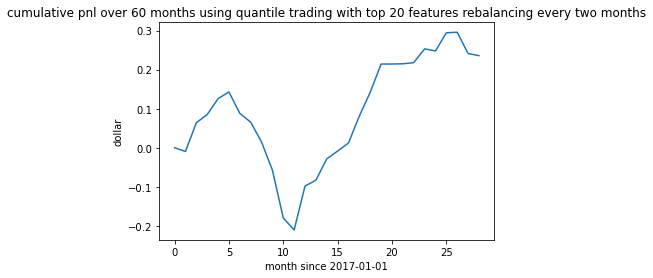

In [201]:
plt.plot(np.cumsum(pnl_all_feature_20_two))
plt.title('cumulative pnl over 60 months using quantile trading with top 20 features rebalancing every two months')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [203]:
pnl_all_feature_10_two = quantile_all_features_two_month(data,top_20_feature[-10:])

Text(0, 0.5, 'dollar')

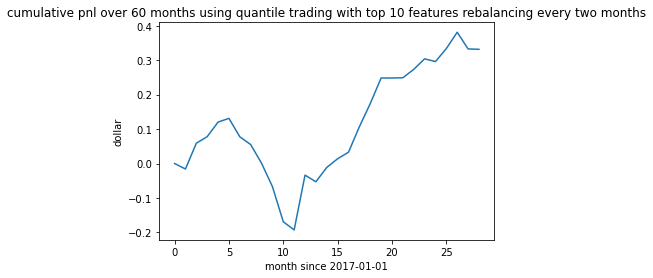

In [204]:
plt.plot(np.cumsum(pnl_all_feature_10_two))
plt.title('cumulative pnl over 60 months using quantile trading with top 10 features rebalancing every two months')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [206]:
pnl_two = quantile_two(data, top_20_feature)

Text(0, 0.5, 'dollar')

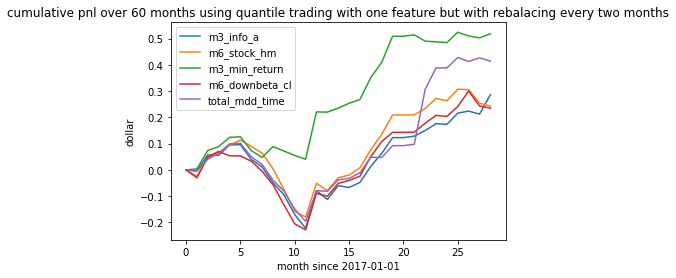

In [208]:
for fea in top_20_feature[-5:]:
    plt.plot(np.cumsum(pnl_two[fea]))
plt.legend(top_20_feature[-5:])
plt.title('cumulative pnl over 60 months using quantile trading with one feature but with rebalacing every two months')
plt.xlabel('month since 2017-01-01')
plt.ylabel('dollar')

In [455]:
import performance_matrix

In [457]:
performance_matrix.performance_matrix()

TypeError: performance_matrix() missing 2 required positional arguments: 'df' and 'metrics'